In [1]:
import tensorflow
import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as img
from cv2 import imread

Using TensorFlow backend.


# Deep Convolutional Neural Network for Automatic De-convolution of Blurry Images

Here I present an interactive notebook that allows you to explore my completed models and test the accuracy on a few sample images. First I load some sample images, then I load the two models (make sure to have the hdf5 files saved in your directory!). I plot a few sample images, and then run a deconvolution script using the predictions made from the output.

In [2]:
import_files = 15 # how many files to import

filelist = os.listdir('convolved') # load all the convolved img filenames
# sometimes this happens - so remove this hidden file just in case
if '.DS_Store' in filelist: filelist.remove('.DS_Store')
filelist = filelist[:import_files] # random images from sample test set
# If we were on our full data set, we would be careful not to use train images

# pre-allocate memory to store our image data, each image 106x106
imgs = np.empty((len(filelist),106,106,1))
rot_lbls = np.empty((len(filelist)))
len_lbls = np.empty((len(filelist)))

for i, file in enumerate(filelist):
    # save as entry in test_img array
    imgs[i] = np.load('convolved/'+file).reshape(106,106,1)
    imgs[i] /= np.max(imgs[i]) # normalize image
    # save labels as integers
    rot_lbls[i] = int(file[:-4].split('_')[-1]) /89 # rotation labels
    len_lbls[i] = (int(file[:-4].split('_')[-2])-4)/16# length labels
    # return image arrays and lables resized to be scales between 0 and 1
 
#load mean image
mean_img = np.load('mean_img.npy').reshape(106,106,1)

In [3]:
# re-load our models
rotmodel = keras.models.load_model('models/rotation_new4.hdf5')
lenmodel = keras.models.load_model('models/length_new_3.hdf5')

# Make predictions
rotpreds = rotmodel.predict(imgs-mean_img).reshape(np.shape(rot_lbls))
lenpreds = lenmodel.predict(imgs-mean_img).reshape(np.shape(len_lbls))

a1= np.average(np.abs(rotpreds*89-rot_lbls*89))
print('Average Angle Difference in test set sample: ', a1)
b1= np.max(rotpreds*89-rot_lbls*89)
print('Maximum Angle Difference in test set sample: ', b1)

a2= np.average(np.abs(lenpreds*16-len_lbls*16))
print('Average Length Difference in test set sample: ', a2)
b2= np.max(abs(lenpreds*16-len_lbls*16))
print('Maximum Length Difference in test set sample: ', b2)

Average Angle Difference in test set sample:  1.2109897931416829
Maximum Angle Difference in test set sample:  3.8811721801757812
Average Length Difference in test set sample:  0.7885548114776612
Maximum Length Difference in test set sample:  2.0371837615966797


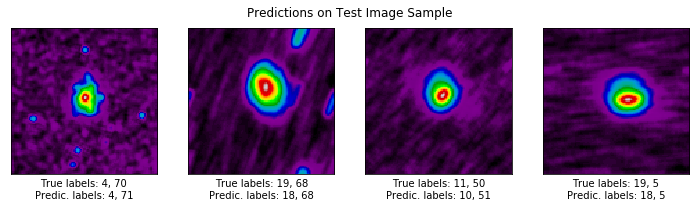

In [11]:
#Show a sample of data
plot = 4 # how many images to plot
plt.nipy_spectral()
plt.figure(figsize=(10,10))
for i in range(plot):
    plt.subplot(plot,plot,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imgs[i].reshape(106,106))
    plt.xlabel('True labels: ' + str(int(len_lbls[i]*16+4)) + ', ' 
               + str(int(rot_lbls[i]*89)) + '\n' + 'Predic. labels: ' + 
               str(int(lenpreds[i]*16+4)) + ', ' + str(int(rotpreds[i]*89)))
plt.suptitle('Predictions on Test Image Sample', y=1.01)
plt.tight_layout()
plt.show()

# Deconvolution Script

In [5]:
def makePSF(length,width,theta,array):
    """ Returns a linear point spread function 
    INPUT: length of x and y blurs, blurry image (to copy shape of array)
    OUTPUT: array of same size as input that defines PSF """   
    # initialize gaussian array of same size as input array
    psf = np.zeros(np.shape(array))
    rows = len(psf[0]) # store dimensions
    cols = len(psf)
    
    psf[cols//2-width//2:cols//2+width//2,rows//2:rows//2+length] = 1. # make linear psf
    psf = img.rotate(psf, theta, reshape=False) # rotate by theta
   
    # transform to corners because of the weird fft indexing
    topleft = np.copy(psf[0:cols//2,0:rows//2])
    topright = np.copy(psf[0:cols//2,rows//2:rows])
    bottleft = np.copy(psf[cols//2:cols,0:rows//2])
    bottright = np.copy(psf[cols//2:cols,rows//2:rows])
    
    psf[0:cols//2,0:rows//2],psf[0:cols//2,rows//2:rows],psf[cols//2:cols,
            0:rows//2],psf[cols//2:cols,rows//2:rows] = bottright,bottleft,topright,topleft
    
    return psf


def deconvolve(Input, psf, epsilon):
  """ Returns the deconvolved (un-blurred) photograph""" 
  InputFFT = np.fft.fft2(Input) # fourier transform blurry image
  psfFFT = np.fft.fft2(psf)+epsilon # fourier transform point spread function
  deconvolved = abs(np.fft.ifft2(InputFFT/psfFFT)) # inverse fourier transform deconvolved image
  return deconvolved

def unblur(image,original=np.array(False)):
    ''' Function that does it all - given a blurry image, run it through the CNN
    to get an output, and deconvolve using the guess PSF. Plot the result.'''
    mean = mean_img.reshape(106,106)
    # make predictions and scale to original values
    rot_pred = int(rotmodel.predict((image-mean).reshape(1,106,106,1))*89)
    len_pred = int(lenmodel.predict((image-mean).reshape(1,106,106,1))*16)+4
    print('Trying to deconvolve image. \n',
          'Guessing PSF Angle = ', rot_pred, '\n',
          'Guessing PSF Length = ', len_pred)
    
    # make the PSF and deconvolve the image
    psf = makePSF(len_pred,4,rot_pred,image)
    deconvolved = deconvolve(image,psf,0.0001)
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,3,1)
    # Plot the deconvolved image
    ax1.imshow(deconvolved)
    ax1.set_title('Deconvolved (un-blurred) Image')
    ax1.set_ylabel('Y Pixels')
    ax1.set_xlabel('X Pixels')
    # Plot the convolved image
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(image)
    ax2.set_title('Convolved (blurry) Image')
    ax2.set_xlabel('X Pixels')
    if original.any(): #Plot the original image only if given
        ax3 = fig.add_subplot(1,3,3)
        ax3.imshow(original)
        ax3.set_title('Original Image')
        ax3.set_xlabel('X Pixels')
    plt.tight_layout()
    plt.show()

# Time to make Unblur Random Images!

I now present a chance to feed random images into the model to see how well it can deconvolve them. To make things easy, we will use a mini-sample from our test image set (Images that the model has never seen before!). Below I print out the images that have been loaded, and in the next cell we call the function to unblur. Try cylcing through a few images and test the accuracy for yourself!

In [6]:
for i in range(len(filelist)):
    print('File #', i,': ', filelist[i]) 
# you can try running the above script with any of these files.
# the first number is the file number, the second is length, and third is angle

File # 0 :  100134_4_70.npy
File # 1 :  100382_19_68.npy
File # 2 :  100078_11_51.npy
File # 3 :  100078_19_5.npy
File # 4 :  100479_8_81.npy
File # 5 :  100506_8_80.npy
File # 6 :  100053_12_7.npy
File # 7 :  100445_20_7.npy
File # 8 :  100263_12_74.npy
File # 9 :  100506_12_68.npy
File # 10 :  100157_18_38.npy
File # 11 :  100434_20_12.npy
File # 12 :  100444_20_88.npy
File # 13 :  100434_11_30.npy
File # 14 :  100023_18_63.npy


Trying to deconvolve image. 
 Guessing PSF Angle =  68 
 Guessing PSF Length =  18


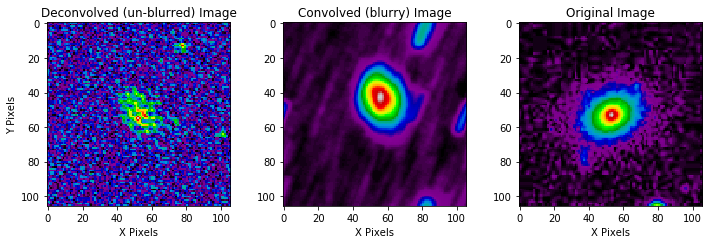

Actual Angle and Length =  68 19


In [20]:
# Note: Only call unblur with original if you are sure that is the correct image!
filenum = 1 # number between 0 and len(filelist)
original = imread('original/100479.jpg',0) # put the correct file number in here 
#original=np.array(False) # otherwise, uncomment this to not plot the original file

unblur(imgs[filenum].reshape(106,106),original)
print('Actual Angle and Length = ', int(rot_lbls[filenum]*89), int(len_lbls[filenum]*16)+4)

You will notice that the model predicts PSF values that sometimes exact, but otherwise just close (usually off by 1). Unfortunately, because of FFT's we need exact values in our PSF to succesfully un-blur images, and so while we are very close, it is often not close enough. Regardless, we have shown a fun proof-of-concept. With a larger training set and more sophisticated model we can expect the above to work exactly for any image. See the project writup for further discussion.